# Data Pipeline Outline:

0. Imports and Configurations
1. Import + Augment Training and Validation Data
2. Data Processing
3. Fit Model & Save Weights
4. Testing & Postprocessing (Graphs, Metrics, Output Examples, etc.)



# 0. Imports and Configurations

In [59]:
%load_ext autoreload
%autoreload 2
import numpy as np
import os
import pandas as pd
from sklearn.metrics import accuracy_score

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model

import matplotlib.pyplot as plt
%matplotlib inline

import models.simpleConv as simpleConv







dataPath = 'RealImageNet/ImageNetSubsample/Data/CLS-LOC'
trainPath = os.path.join(dataPath, 'train')
testPath = os.path.join(dataPath, 'test')
validationPath = os.path.join(dataPath, 'val')

img_width, img_height = 224, 224

useGrayscale=False
if useGrayscale:
    color_mode='grayscale'
    num_channels=1
else:
    color_mode='rgb'
    num_channels=3
    
    
outputPath = os.path.join('output','saved-models')

saveModel = True
loadModel = False
if(loadModel):
    loadModelPath = os.path.join(outputPath, "model1.h5")
    if not os.path.exists(loadModelPath):
        print("No such model file: " + loadModelPath)


modelName = "model1"

if not os.path.isdir(outputPath):
    os.makedirs(outputPath)
    
lines = [line.rstrip('\n').split() for line in open('RealImageNet/LOC_synset_mapping.txt')]
wnids_to_words = {line[0]:' '.join(line[1:]) for line in lines }

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Load Training and Validation Data


In [60]:

# train_datagen = ImageDataGenerator(rescale=1./255, 
#                                    shear_range=0.2, 
#                                    zoom_range=0.2, 
#                                    horizontal_flip=True, 
#                                    validation_split=0.1)

train_datagen = ImageDataGenerator(validation_split=0.1, rescale=1./255)


    
train_generator = train_datagen.flow_from_directory('RealImageNet/ImageNetSubsample/Data/CLS-LOC/train',
                                                   target_size=(img_width, img_height),
                                                   batch_size=16,
                                                   class_mode='categorical',
                                                   color_mode=color_mode,
                                                   subset='training')



val_generator = train_datagen.flow_from_directory('RealImageNet/ImageNetSubsample/Data/CLS-LOC/train',
                                                   target_size=(img_width, img_height),
                                                   batch_size=16,
                                                   class_mode='categorical',
                                                   color_mode='rgb',
                                                   subset='validation')





Found 5850 images belonging to 5 classes.
Found 650 images belonging to 5 classes.


# 2. Data Processing



# 3. Fit Model & Save Weights

In [61]:

#Generate unique model name so as not to overwrite previously saved model on disk. 
count = 1 
name = "" 
while True:     
    s = modelName[:-1] + str(count) + ".h5"     
    if not s in os.listdir(outputPath):         
        name = s         
        break     
    else:         
        count+=1 
print(name)

#load model if necessary, otherwise build a new model
if loadModel:
    model = load_model(loadModelPath)
else:
    model = simpleConv.build_model(img_width, img_height, num_channels)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    results = model.fit_generator(
            train_generator,
            validation_data=val_generator,
            steps_per_epoch=3,
            epochs=5)


if saveModel:
    model.save(os.path.join(outputPath, name))

model12.h5
Epoch 1/5
3/3 [==============================] - 20s 7s/step - loss: 1.7130 - acc: 0.2083 - val_loss: 1.5777 - val_acc: 0.3738
Epoch 2/5
3/3 [==============================] - 20s 7s/step - loss: 1.5731 - acc: 0.2708 - val_loss: 1.4635 - val_acc: 0.4231
Epoch 3/5
3/3 [==============================] - 20s 7s/step - loss: 1.4041 - acc: 0.3958 - val_loss: 1.1966 - val_acc: 0.3569
Epoch 4/5
3/3 [==============================] - 20s 7s/step - loss: 1.1647 - acc: 0.4167 - val_loss: 1.3989 - val_acc: 0.3738
Epoch 5/5
3/3 [==============================] - 19s 6s/step - loss: 1.1425 - acc: 0.4167 - val_loss: 1.1923 - val_acc: 0.3677


# 4. Testing & Post-Processing (Metrics, Graphs, etc.)

## Plot Training Results

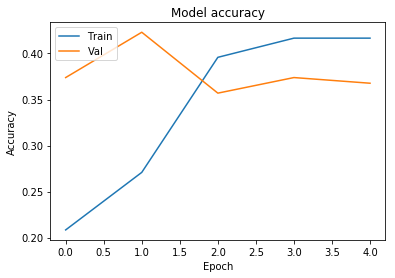

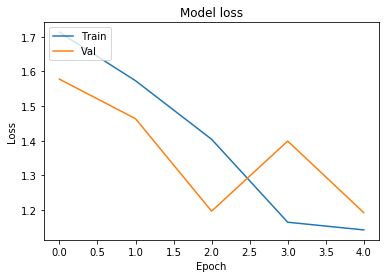

In [62]:


# Plot training & validation accuracy values
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
# plt.ylim(0.5, 1.0)
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
# plt.ylim(0, 0.7)
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

## Analyze Predictions on Dataset (via Generator)

In [63]:
def results_from_generator(generator):
#     generator.reset()
    pred = model.predict_generator(generator, verbose=1)

    pred_class_indices = np.argmax(pred, axis=1)
    labels = (generator.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    predictions = [labels[k] for k in pred_class_indices]


    filenames = generator.filenames
    true_class = [x.split('/')[0] for x in generator.filenames]

    true_class_deciphered = [wnids_to_words[x] for x in true_class]
    predictions_deciphered = [wnids_to_words[x] for x in predictions]

    results = pd.DataFrame({'filename':filenames, 
                            'true_class': true_class_deciphered, 
                            "pred_class": predictions_deciphered})


    accuracy = accuracy_score(results['true_class'], results['pred_class'])
    
    return results, accuracy, labels
    
val_results, val_accuracy, val_labels = results_from_generator(val_generator)
print("Val Accuracy = {0}".format(val_accuracy))

train_results, train_accuracy, train_labels = results_from_generator(train_generator)
print("Train Accuracy = {0}".format(train_accuracy)) 

41/41 [==============================] - 15s 375ms/step
Val Accuracy = 0.2076923076923077
366/366 [==============================] - 144s 394ms/step
Train Accuracy = 0.20017094017094017


## Sample Results

In [64]:
val_results

,filename,true_class,pred_class
0,n01440764/n01440764_10026.JPEG,"tench, Tinca tinca","goldfish, Carassius auratus"
1,n01440764/n01440764_10027.JPEG,"tench, Tinca tinca","goldfish, Carassius auratus"
2,n01440764/n01440764_10029.JPEG,"tench, Tinca tinca","great white shark, white shark, man-eater, man..."
3,n01440764/n01440764_10040.JPEG,"tench, Tinca tinca","goldfish, Carassius auratus"
4,n01440764/n01440764_10042.JPEG,"tench, Tinca tinca","great white shark, white shark, man-eater, man..."
5,n01440764/n01440764_10043.JPEG,"tench, Tinca tinca","great white shark, white shark, man-eater, man..."
6,n01440764/n01440764_10048.JPEG,"tench, Tinca tinca","great white shark, white shark, man-eater, man..."
7,n01440764/n01440764_10066.JPEG,"tench, Tinca tinca","goldfish, Carassius auratus"
8,n01440764/n01440764_10074.JPEG,"tench, Tinca tinca","great white shark, white shark, man-eater, man..."
9,n01440764/n01440764_1009.JPEG,"tench, Tinca tinca","great white shark, white shark, man-eater, man..."


In [7]:
# #displaying an image from the generator

# # train_generator.reset()
# x,y = train_generator.next()
# plt.imshow(x[0]/255.)

label: tench, Tinca tinca


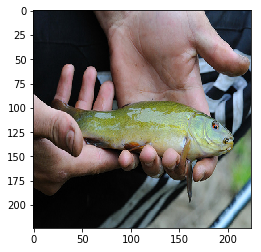

In [56]:
def getImageFromFile(filename):
    img = load_img(filename, target_size=(img_width, img_height))
    x = img_to_array(img)
    return x
    
idx = np.random.randint(0, 649)
img = getImageFromFile(os.path.join(trainPath, val_results['filename'][idx]))
print('label: ' + val_results['true_class'][idx])
plt.imshow(img/255.)


In [57]:
p = model.predict(np.expand_dims(img, axis=0))

In [58]:
print(p)

[[2.53213257e-30 0.00000000e+00 1.41784536e-11 1.00000000e+00
  2.25468238e-19]]


In [49]:
wnids_to_words[val_labels[np.argmax(p)]]

'tench, Tinca tinca'

In [50]:
pc = model.predict_classes(np.expand_dims(img, axis=0))

In [51]:
p

array([[1.0000000e+00, 3.7984775e-34, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00]], dtype=float32)